In [25]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [4]:
sys.path.append('../scripts')  # Add the scripts directory to the path
from load_data import load_data
from aggregiate_metrics import aggregate_user_metrics
from normalize_and_cluster import normalize_metrics, run_kmeans


### Data Loading and Initial Processing

In [5]:
df = aggregate_user_metrics()

Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed


In [6]:
df.head()

,msisdn,session_count,total_duration,total_dl,total_ul,social_media_total,google_total,email_total,youtube_total,netflix_total,gaming_total,other_total
0,3.360100e+10,1,116720.0,8.426375e+08,36053108.0,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
1,3.360100e+10,1,181230.0,1.207552e+08,36104459.0,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
2,3.360100e+10,1,134969.0,5.566597e+08,39306820.0,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3,3.360101e+10,1,49878.0,4.019932e+08,20327526.0,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
4,3.360101e+10,2,37104.0,1.363130e+09,94280527.0,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


In [15]:
df.columns

Index(['msisdn', 'session_count', 'total_duration', 'total_dl', 'total_ul',
       'social_media_total', 'google_total', 'email_total', 'youtube_total',
       'netflix_total', 'gaming_total', 'other_total'],
      dtype='object')

In [7]:
# :Handle missing data (if any)
if df.isnull().sum().sum() > 0:
    print("Missing values detected. Filling with column mean...")   
    df = df.fillna(df.mean())  # Fill missing values with column mean


Missing values detected. Filling with column mean...


### Basic Statistical Analysis



In [12]:
print("\nBasic Statistics:")
basic_stats = df.describe()
print(basic_stats)
# Dispersion Analysis
dispersion_stats = df.agg(['var', 'std', 'skew', 'kurt'])
print("\nDispersion Statistics:")
dispersion_stats


Basic Statistics:
             msisdn  session_count  total_duration      total_dl  \
count  1.068570e+05  106857.000000    1.068570e+05  1.068570e+05   
mean   4.511474e+10       1.403755    1.468438e+05  6.382035e+08   
std    2.889410e+12       3.355032    2.892198e+05  1.558474e+09   
min    3.360100e+10       1.000000    7.142000e+03  8.827082e+06   
25%    3.365088e+10       1.000000    7.130900e+04  3.148302e+08   
50%    3.366365e+10       1.000000    1.027410e+05  5.703713e+08   
75%    3.368344e+10       2.000000    1.727990e+05  8.073701e+08   
max    8.823971e+14    1066.000000    7.244640e+07  4.869236e+11   

           total_ul  social_media_total  google_total   email_total  \
count  1.068570e+05        1.068570e+05  1.068570e+05  1.068570e+05   
mean   5.772370e+07        2.566415e+06  1.095953e+07  3.171225e+06   
std    1.400375e+08        6.325032e+06  2.630542e+07  7.661339e+06   
min    2.866892e+06        1.563000e+03  4.033000e+04  1.817600e+04   
25%    3.6395

,msisdn,session_count,total_duration,total_dl,total_ul,social_media_total,google_total,email_total,youtube_total,netflix_total,gaming_total,other_total
var,8.348690e+24,11.256237,8.364809e+10,2.428841e+18,1.961050e+16,4.000603e+13,6.919751e+14,5.869612e+13,5.983623e+15,5.943821e+15,2.189520e+18,2.099786e+18
std,2.889410e+12,3.355032,2.892198e+05,1.558474e+09,1.400375e+08,6.325032e+06,2.630542e+07,7.661339e+06,7.735388e+07,7.709618e+07,1.479703e+09,1.449064e+09
skew,2.813484e+02,299.048050,1.516867e+02,2.843610e+02,2.956670e+02,2.833568e+02,2.874504e+02,2.865681e+02,2.904953e+02,2.902735e+02,2.828265e+02,2.810362e+02
kurt,8.311516e+04,94877.972981,3.675818e+04,8.871113e+04,9.344964e+04,8.829338e+04,8.999887e+04,8.963015e+04,9.127405e+04,9.118141e+04,8.807288e+04,8.732944e+04


### Decile Analysis 


In [16]:
print("\nAnalyzing user deciles...")
df['duration_decile'] = pd.qcut(df['total_duration'], 
                              q=10, 
                              labels=['D1', 'D2', 'D3', 'D4', 'D5', 
                                    'D6', 'D7', 'D8', 'D9', 'D10'])
# Calculate total data per user
df['total_data'] = df['total_dl'] + df['total_ul']
decile_stats = df.groupby('duration_decile').agg({
   'total_data': ['sum', 'mean', 'median']
}).round(2)
print("\nDecile Statistics:")
print(decile_stats)


Analyzing user deciles...

Decile Statistics:
                   total_data                            
                          sum          mean        median
duration_decile                                          
D1               5.439277e+12  5.089144e+08  5.052998e+08
D2               6.109410e+12  5.718280e+08  5.552975e+08
D3               6.536402e+12  6.083769e+08  5.893881e+08
D4               6.034241e+12  4.994406e+08  5.012093e+08
D5               5.144182e+12  5.572724e+08  5.407249e+08
D6               6.425801e+12  6.013852e+08  5.749308e+08
D7               6.152478e+12  5.757512e+08  5.534024e+08
D8               7.822234e+12  7.320077e+08  7.022124e+08
D9               9.306258e+12  8.709647e+08  8.057182e+08
D10              1.539441e+13  1.440615e+09  1.260276e+09


### Application Usage Analysis

In [18]:
# Calculate total traffic per application
total_traffic_per_app = {
   'YouTube': df['youtube_total'].sum(),
   'Gaming': df['gaming_total'].sum(),
   'Social Media': df['social_media_total'].sum(),
   'Google': df['google_total'].sum(),
   'Email': df['email_total'].sum(),
   'Netflix': df['netflix_total'].sum(),
   'Other': df['other_total'].sum()
}
print("\nTotal Traffic per Application:")
total_traffic_per_app



Total Traffic per Application:


{'YouTube': 3396545039272.6387,
 'Gaming': 64550395439016.7,
 'Social Media': 274239359454.20804,
 'Google': 1171101989130.5457,
 'Email': 338867605596.30994,
 'Netflix': 3394313609363.5386,
 'Other': 64405230908181.62}

### Correlation Analysis





In [21]:
# Define app_columns first
app_columns = [
   'social_media_total', 
   'google_total', 
   'email_total', 
   'youtube_total', 
   'netflix_total', 
   'gaming_total',
]

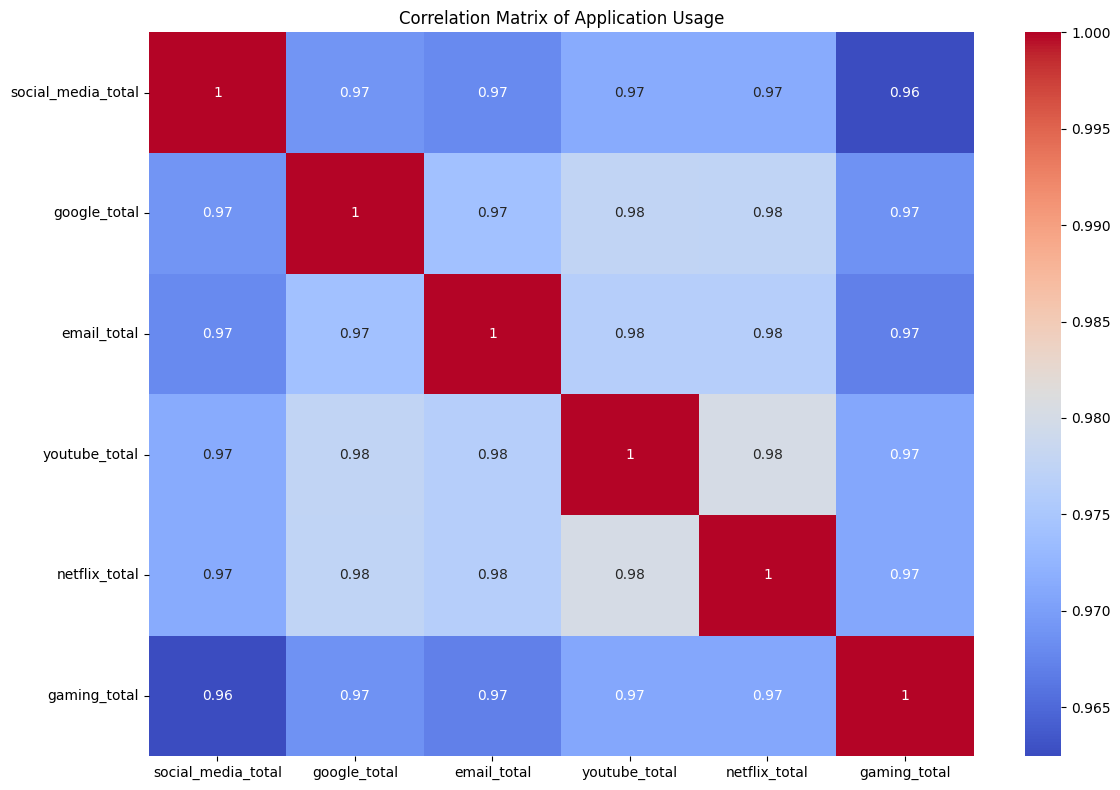


Strong correlations (>0.7):
social_media_total vs google_total: 0.97
social_media_total vs email_total: 0.97
social_media_total vs youtube_total: 0.97
social_media_total vs netflix_total: 0.97
social_media_total vs gaming_total: 0.96
google_total vs email_total: 0.97
google_total vs youtube_total: 0.98
google_total vs netflix_total: 0.98
google_total vs gaming_total: 0.97
email_total vs youtube_total: 0.98
email_total vs netflix_total: 0.98
email_total vs gaming_total: 0.97
youtube_total vs netflix_total: 0.98
youtube_total vs gaming_total: 0.97
netflix_total vs gaming_total: 0.97


In [22]:
correlation_matrix = df[app_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Application Usage')
plt.tight_layout()
plt.show()
# Print strong correlations
print("\nStrong correlations (>0.7):")
for i in range(len(app_columns)):
   for j in range(i+1, len(app_columns)):
       corr = correlation_matrix.iloc[i,j]
       if abs(corr) > 0.7:
           print(f"{app_columns[i]} vs {app_columns[j]}: {corr:.2f}")

### PCA Analysis



PCA Analysis:
Explained variance ratio: [0.91612615 0.07987394 0.00399991]


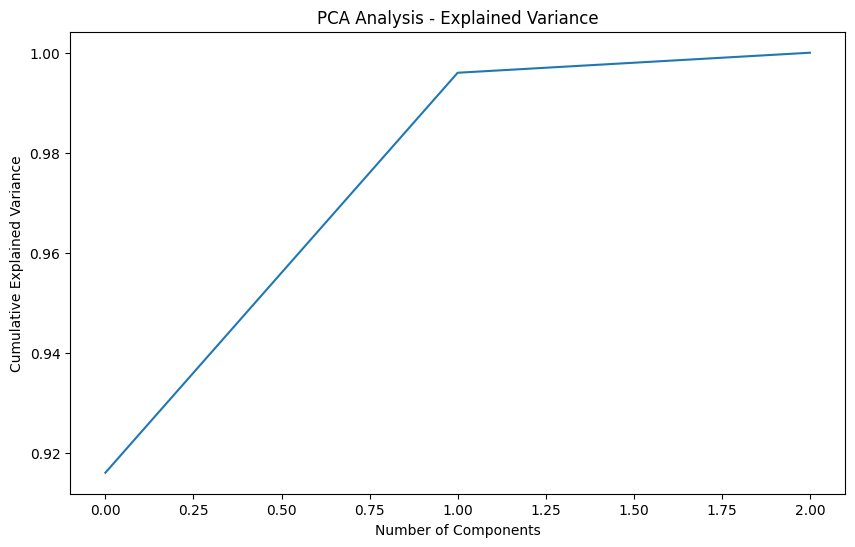

In [26]:
### Select features for PCA
features_for_pca = ['session_count', 'total_duration', 'total_data']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_for_pca])
pca = PCA()
pca_result = pca.fit_transform(scaled_features)
print("\nPCA Analysis:")
print("Explained variance ratio:", pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis - Explained Variance')
plt.show()

### Clustering Analysis


In [28]:
### Normalize metrics for clustering
columns_to_normalize = ['session_count', 'total_duration', 'total_data']
df_normalized = df.copy()
scaler = MinMaxScaler()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [30]:
# Find optimal k using elbow method
wcss = []
for i in range(1, 11):
   kmeans = KMeans(n_clusters=i, random_state=42)
   kmeans.fit(df_normalized[columns_to_normalize])
   wcss.append(kmeans.inertia_)

c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

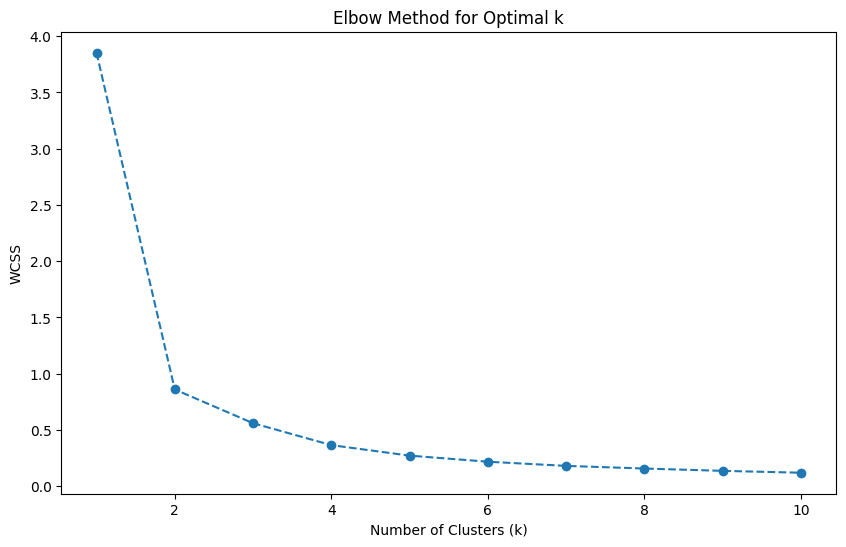

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [32]:
# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df_normalized[columns_to_normalize])

c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [35]:
# Analyze clusters
cluster_stats = df.groupby('cluster').agg({
    'session_count': ['min', 'max', 'mean', 'sum'],
    'total_duration': ['min', 'max', 'mean', 'sum'],
    'total_data': ['min', 'max', 'mean', 'sum']
})
print("\nCluster Statistics:")
cluster_stats


Cluster Statistics:


session_count                            total_duration              \
                  min   max         mean     sum            min         max   
cluster                                                                       
0                   1     6     1.249395  123990         7142.0    404446.0   
1                1066  1066  1066.000000    1066     72446396.0  72446396.0   
2                   1    18     3.275341   24945       170680.0  18553754.0   

                                       total_data                              \
                 mean           sum           min           max          mean   
cluster                                                                         
0        1.156391e+05  1.147602e+10  3.324901e+07  3.271920e+09  6.172992e+08   
1        7.244640e+07  7.244640e+07  5.312489e+11  5.312489e+11  5.312489e+11   
2        5.439618e+05  4.142813e+09  5.714004e+07  8.846226e+09  1.650824e+09   

                       
                  sum  
cluster                
0        6.126077e+13  
1        5.312489e+11  
2        1.257267e+13

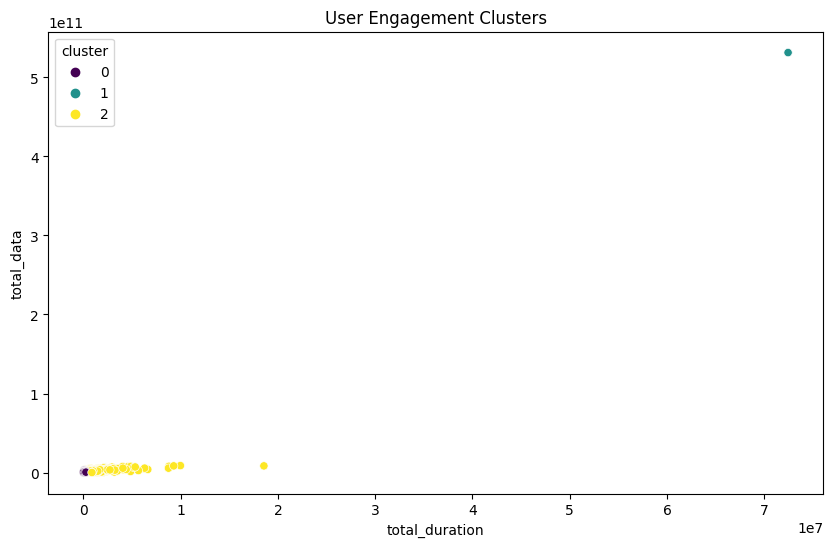

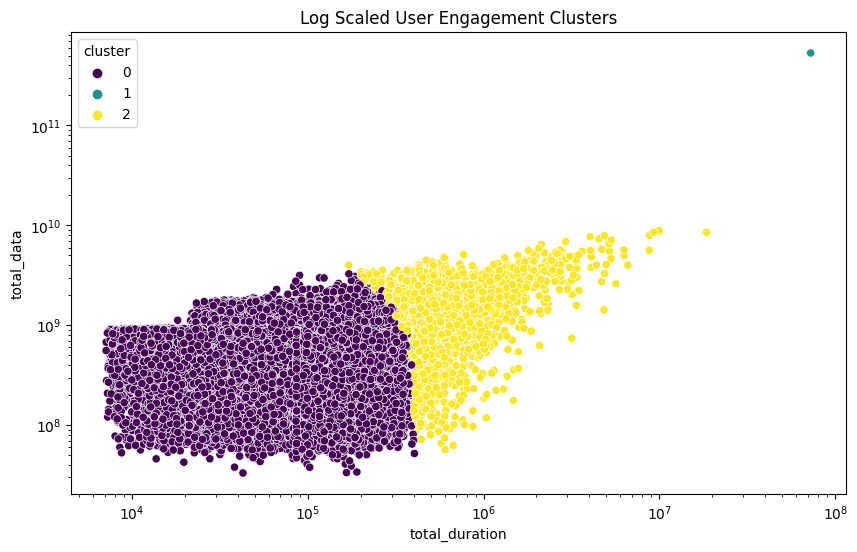

In [38]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, 
                x='total_duration', 
                y='total_data',
                hue='cluster',
                palette='viridis')
plt.title('User Engagement Clusters')
plt.show()

#log scale
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, 
                x='total_duration', 
                y='total_data',
                hue='cluster',
                palette='viridis')
plt.title('Log Scaled User Engagement Clusters')
plt.xscale('log')
plt.yscale('log')
plt.show()


### Top Users Analysis


Top 10 users by social_media_total:
              msisdn  social_media_total
106856  4.511474e+10        1.973817e+09
13526   3.362632e+10        4.337478e+07
92923   3.376054e+10        3.978319e+07
37052   3.365973e+10        3.541236e+07
6437    3.361489e+10        2.829454e+07
13180   3.362578e+10        2.713550e+07
65118   3.366716e+10        2.424785e+07
106137  3.378632e+10        2.397492e+07
70960   3.366907e+10        2.380083e+07
666     3.360313e+10        2.307782e+07

Top 10 users by google_total:
              msisdn  google_total
106856  4.511474e+10  8.248577e+09
13526   3.362632e+10  1.521919e+08
13180   3.362578e+10  1.423079e+08
6437    3.361489e+10  1.279738e+08
92923   3.376054e+10  1.232231e+08
37052   3.365973e+10  1.165163e+08
106137  3.378632e+10  1.102545e+08
76363   3.367588e+10  1.098605e+08
65118   3.366716e+10  1.050327e+08
94654   3.376127e+10  9.708999e+07

Top 10 users by email_total:
              msisdn   email_total
106856  4.511474e+10  2.399880e

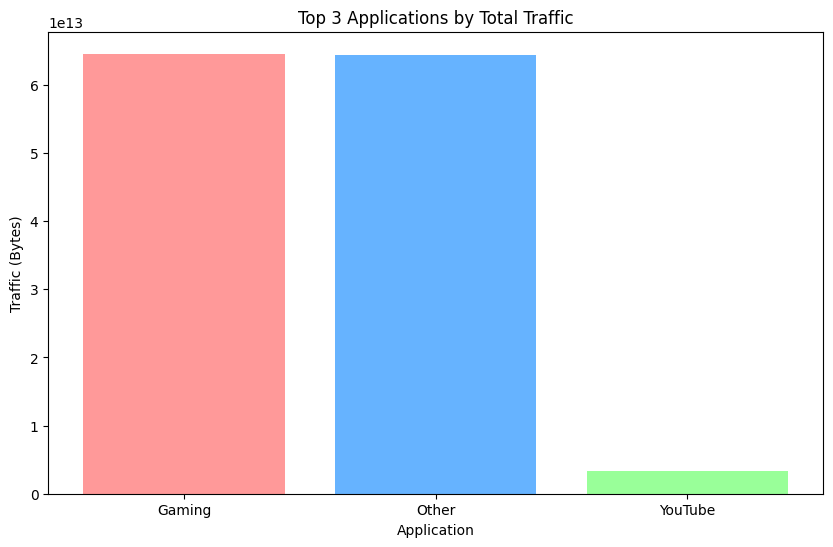

In [39]:
for col in app_columns:
    print(f"\nTop 10 users by {col}:")
    print(df.nlargest(10, col)[['msisdn', col]])

# Plot top 3 applications by total usage
top_3_apps = dict(sorted(total_traffic_per_app.items(), 
                        key=lambda x: x[1], 
                        reverse=True)[:3])

plt.figure(figsize=(10, 6))
plt.bar(top_3_apps.keys(), 
        top_3_apps.values(), 
        color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Top 3 Applications by Total Traffic')
plt.xlabel('Application')
plt.ylabel('Traffic (Bytes)')
plt.show()